In this notebook we generate mnist dataset examples by using Deep Convolutional Generative Adversarial network.

### Starting with libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import tensorflow.keras as keras
import time
%matplotlib inline

As we are gonna use tangent hyperbolic function(-1,1) in our generator so we shall scale our data to zero mean with limits(-1,1).

In [2]:
train,test=mnist.load_data()
x,y=train
x=(x-127.5)/127.5
x=np.expand_dims(x,3)

Creating a function to display images in tiles form

In [3]:
def show_data(data,r,c,w=2,size=(8,8),batch=0):
    """
    The function displays data points in tiles form.
    
    Args: 
        data: The tensor containing datapoints.
        l: number of images to be arranged in rows.
        b: number of images to be arranged in columns.
        w: width of separator between images.
        size: sigure size
        
    Returns:
        None
    """
    img=iter(tf.constant(data))

    for i in range(1,(r*c)+1):

        if i%c==1:
            arr=img.__next__().numpy()
            continue

        arr=np.append(arr,np.ones((28,w,1))*arr.max(),axis=1)
        arr=np.concatenate([arr,img.__next__().numpy()],axis=1)

        if i%c==0.0:
            if i/c==1.0:
                fig=arr
            else:
                fig=np.concatenate([fig,np.ones((w,fig.shape[1],1))*arr.max()],axis=0)
                fig=np.concatenate([fig,arr],axis=0)

    figure=plt.figure(figsize=size)
    plt.imshow(fig,'gray')
    plt.xticks([])
    plt.yticks([])
    figure.savefig("mnist_%d.png"%(batch))
    plt.show()

### Creating model

The Generator:- Generates images from random noise of a specific shape. This includes:-<br>
<br>
>*Convolutional transpose layer which is convolution in reverse direction, i.e. increasing strides increases size of output image thus no need to up sample. <br>
*Batch normalization is used to normalize output from layers to a standard mean with beta=0.8 in order to make learning process stable.
*Dropout layer is not used as its combination with batch normalization layer may cause unstablity.<br>
*For activation we use Leaky Relu which gives a small value rather than zero when input is less than negative.<br>
*At last we use tangent hyperbolic function as activation to give output as an image.

In [4]:
def generator(noise_shape):
    inp=keras.layers.Input(noise_shape)
    x=keras.layers.Dense(7*7*256,name='Dense_layer')(inp)
    x=keras.layers.LeakyReLU()(x)
    x=keras.layers.Reshape((7,7,256))(x)
    assert tuple(x.shape)==(None, 7, 7, 256)
    
    x=keras.layers.Conv2DTranspose(128,kernel_size=(4,4),strides=(1,1),padding='same',\
                                   name='ConvT_layer_1')(x)
    x=keras.layers.BatchNormalization(momentum=0.8)(x)
    x=keras.layers.LeakyReLU()(x)
    assert tuple(x.shape)==(None,7,7,128)
    
    x=keras.layers.Conv2DTranspose(64,kernel_size=(4,4),strides=(2,2),padding='same',\
                                  name='ConvT_layer_2')(x)
    x=keras.layers.BatchNormalization(momentum=0.8)(x)
    x=keras.layers.LeakyReLU()(x)
    assert tuple(x.shape)==(None,14,14,64)
    
    x=keras.layers.Conv2DTranspose(1,kernel_size=(4,4),strides=(2,2),padding='same',\
                                  name='ConvT_layer_3')(x)
    x=keras.layers.BatchNormalization(momentum=0.8)(x)
    out=keras.layers.Activation('tanh')(x)
    assert tuple(x.shape)==(None,28,28,1)
    
    return keras.models.Model(inp,out)

The Discriminator:- This is a simple convolutional network which takes input as image and predicts fake or real using sigmoid as activation function.

In [5]:
def discriminator(img_size):
    inp=keras.layers.Input(img_size)
    x=keras.layers.Conv2D(32,kernel_size=(5,5),strides=(1,1),padding='same')(inp)
    x=keras.layers.LeakyReLU(alpha=0.2)(x)
    x=keras.layers.Dropout(0.2)(x)
    
    x=keras.layers.Conv2D(64,kernel_size=(5,5),strides=(1,1),padding='same')(x)
    x=keras.layers.LeakyReLU(alpha=0.2)(x)
    x=keras.layers.Dropout(0.2)(x)
    
    x=keras.layers.Conv2D(128,kernel_size=(5,5),strides=(1,1),padding='same')(x)
    x=keras.layers.LeakyReLU(alpha=0.2)(x)
    x=keras.layers.Dropout(0.2)(x)
    
    x=keras.layers.Flatten()(x)
    x=keras.layers.Dense(1)(x)
    out=keras.layers.Activation('sigmoid')(x)
    
    return keras.models.Model(inp,out)

### Creating an instance of model

Optimizer used is ADAM which not only adapts step size but works with momentum too thus results in stable learning process.

While creating a combined model we initialize discriminater as non trainable and then compile to see the effect. Thus the generator and discrimator are trained separately.
Where, loss is binary cross entropy. 

In [6]:
def DCGAN():
    opt=keras.optimizers.Adam(lr=0.0002,beta_1=0.5)
    dis=discriminator((28,28,1))
    dis.compile(optimizer=opt,loss='binary_crossentropy',metrics=['accuracy'])
    
    gen=generator((100,))
    inp=keras.layers.Input((100,))
    x=gen(inp)
    
    dis.trainable=False
    out=dis(x)
    combined=keras.models.Model(inp,out)
    combined.compile(optimizer=opt,loss='binary_crossentropy')
    
    return gen,dis,combined

In [7]:
gen,disc,combined=DCGAN()

### Training process

In [8]:
def train_model(dis,comb,batch_size,batch_len,data):
    w=int(np.sqrt(batch_size))
    t0=time.time()
    for i in range(1,batch_len+1):
        t1=time.time()
        inp=tf.random.normal(mean=0,stddev=1,shape=(batch_size,100,))
        x_fake=gen(inp)
        y_fake=tf.zeros((batch_size,))
        
        ind=np.random.randint(0,len(data),batch_size)
        x_real=data[(ind)]
        y_real=tf.ones((batch_size,))
        
        loss_fk=dis.train_on_batch(x_fake,y_fake)
        loss_rl=dis.train_on_batch(x_real,y_real)
        total_loss,acc=0.5*np.add(loss_fk,loss_rl)
        
        g_loss=comb.train_on_batch(inp,y_real)
        t2=time.time()
        if (i%100==0) and (i>1):
            print("Batch: %d/%d [G-Loss: %.3f, D-Loss: %.3f, Accuracy: %.2f%%] [Batch time: %.3f sec, Total time: %.2f min]\n"\
                  %(i,batch_len,g_loss,total_loss,acc*100,t2-t1,(t2-t0)/60))
            show_data(x_fake,w,w,size=(5,5),batch=i)

Batch: 100/1000 [G-Loss: 5.483, D-Loss: 0.210, Accuracy: 90.62%] [Batch time: 0.833 sec, Total time: 1.38 min]



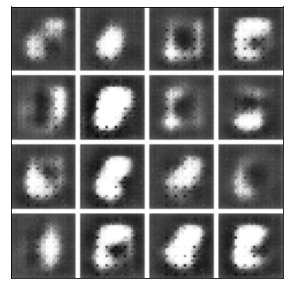

Batch: 200/1000 [G-Loss: 5.966, D-Loss: 0.005, Accuracy: 100.00%] [Batch time: 0.829 sec, Total time: 2.77 min]



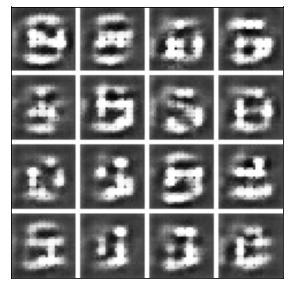

Batch: 300/1000 [G-Loss: 7.121, D-Loss: 0.001, Accuracy: 100.00%] [Batch time: 0.822 sec, Total time: 4.16 min]



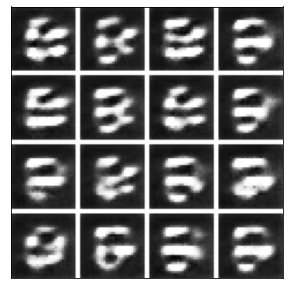

Batch: 400/1000 [G-Loss: 5.882, D-Loss: 0.003, Accuracy: 100.00%] [Batch time: 0.837 sec, Total time: 5.55 min]



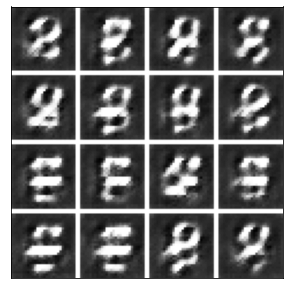

Batch: 500/1000 [G-Loss: 6.762, D-Loss: 0.007, Accuracy: 100.00%] [Batch time: 0.839 sec, Total time: 6.97 min]



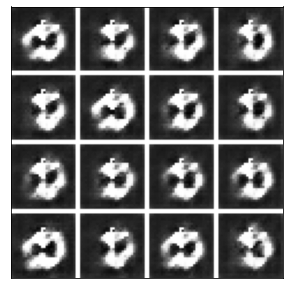

Batch: 600/1000 [G-Loss: 5.593, D-Loss: 0.004, Accuracy: 100.00%] [Batch time: 0.840 sec, Total time: 8.36 min]



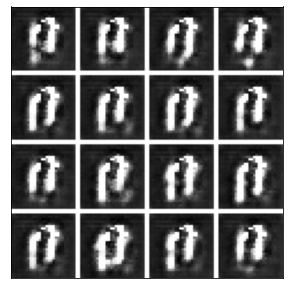

Batch: 700/1000 [G-Loss: 5.248, D-Loss: 0.003, Accuracy: 100.00%] [Batch time: 0.824 sec, Total time: 9.75 min]



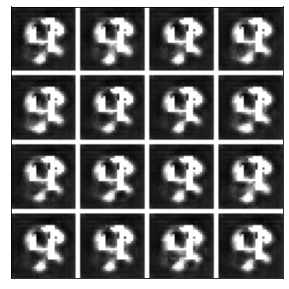

Batch: 800/1000 [G-Loss: 6.575, D-Loss: 0.002, Accuracy: 100.00%] [Batch time: 0.802 sec, Total time: 11.10 min]



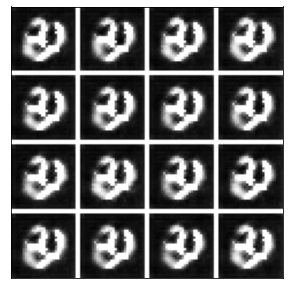

Batch: 900/1000 [G-Loss: 7.231, D-Loss: 0.001, Accuracy: 100.00%] [Batch time: 0.816 sec, Total time: 12.48 min]



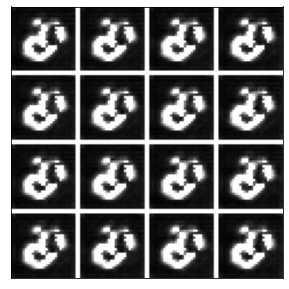

Batch: 1000/1000 [G-Loss: 4.435, D-Loss: 0.016, Accuracy: 100.00%] [Batch time: 0.877 sec, Total time: 13.91 min]



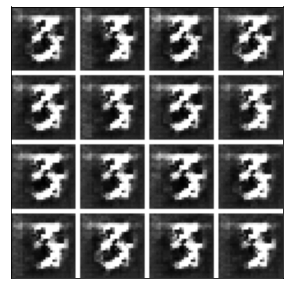

In [9]:
train_model(disc,combined,16,batch_len=1000,data=x)

Batch: 100/3000 [G-Loss: 4.893, D-Loss: 0.028, Accuracy: 100.00%] [Batch time: 0.915 sec, Total time: 1.42 min]



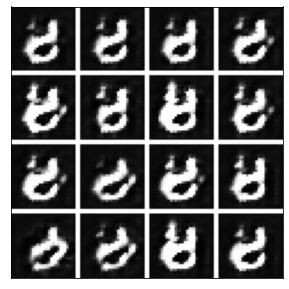

Batch: 200/3000 [G-Loss: 4.987, D-Loss: 0.009, Accuracy: 100.00%] [Batch time: 0.863 sec, Total time: 2.88 min]



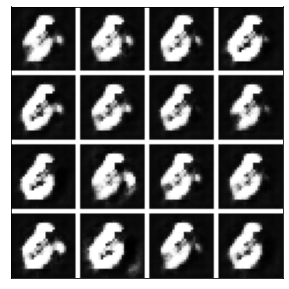

Batch: 300/3000 [G-Loss: 10.088, D-Loss: 0.116, Accuracy: 96.88%] [Batch time: 0.808 sec, Total time: 4.33 min]



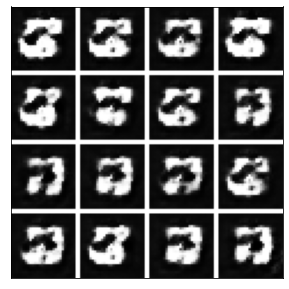

Batch: 400/3000 [G-Loss: 3.060, D-Loss: 0.059, Accuracy: 96.88%] [Batch time: 0.844 sec, Total time: 5.73 min]



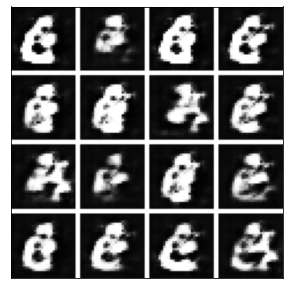

Batch: 500/3000 [G-Loss: 6.063, D-Loss: 0.003, Accuracy: 100.00%] [Batch time: 0.830 sec, Total time: 7.14 min]



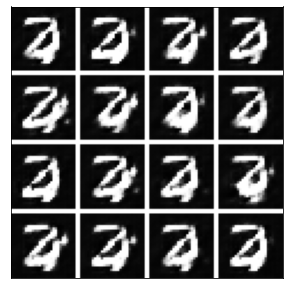

Batch: 600/3000 [G-Loss: 3.533, D-Loss: 0.059, Accuracy: 96.88%] [Batch time: 0.821 sec, Total time: 8.53 min]



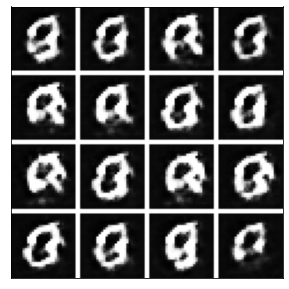

Batch: 700/3000 [G-Loss: 8.764, D-Loss: 0.014, Accuracy: 100.00%] [Batch time: 0.826 sec, Total time: 9.92 min]



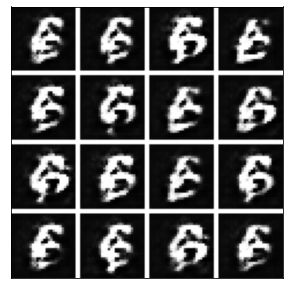

Batch: 800/3000 [G-Loss: 7.151, D-Loss: 0.057, Accuracy: 96.88%] [Batch time: 0.850 sec, Total time: 11.31 min]



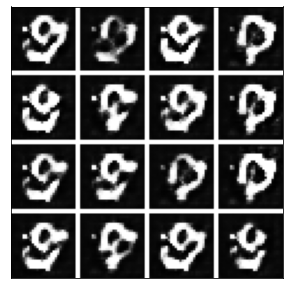

Batch: 900/3000 [G-Loss: 5.612, D-Loss: 0.026, Accuracy: 100.00%] [Batch time: 0.818 sec, Total time: 12.70 min]



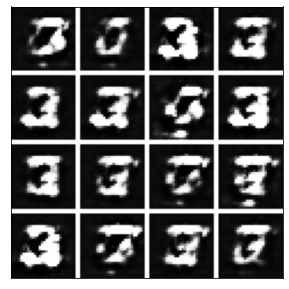

Batch: 1000/3000 [G-Loss: 5.843, D-Loss: 0.012, Accuracy: 100.00%] [Batch time: 0.828 sec, Total time: 14.09 min]



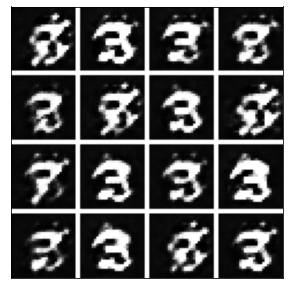

Batch: 1100/3000 [G-Loss: 6.883, D-Loss: 0.005, Accuracy: 100.00%] [Batch time: 0.831 sec, Total time: 15.48 min]



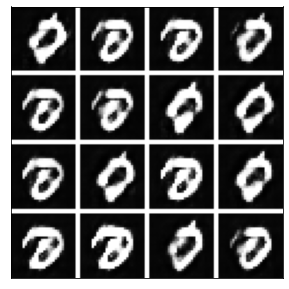

Batch: 1200/3000 [G-Loss: 5.065, D-Loss: 0.009, Accuracy: 100.00%] [Batch time: 0.827 sec, Total time: 16.87 min]



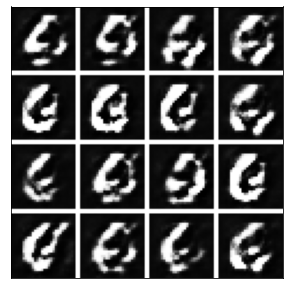

Batch: 1300/3000 [G-Loss: 6.251, D-Loss: 0.057, Accuracy: 100.00%] [Batch time: 0.857 sec, Total time: 18.27 min]



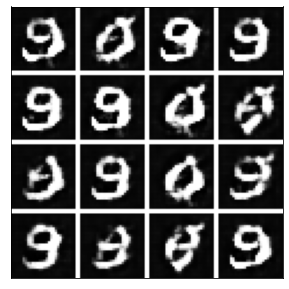

Batch: 1400/3000 [G-Loss: 6.070, D-Loss: 0.033, Accuracy: 96.88%] [Batch time: 0.822 sec, Total time: 19.65 min]



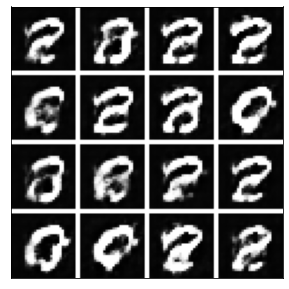

Batch: 1500/3000 [G-Loss: 3.351, D-Loss: 0.085, Accuracy: 96.88%] [Batch time: 0.822 sec, Total time: 21.04 min]



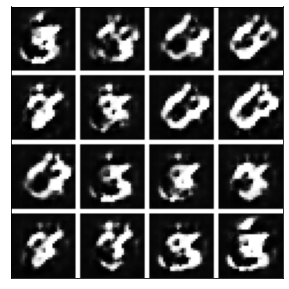

Batch: 1600/3000 [G-Loss: 4.807, D-Loss: 0.043, Accuracy: 100.00%] [Batch time: 0.817 sec, Total time: 22.43 min]



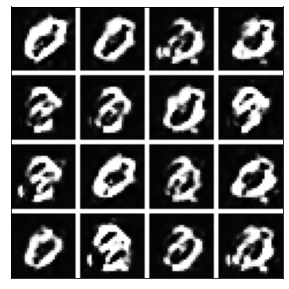

Batch: 1700/3000 [G-Loss: 4.397, D-Loss: 0.014, Accuracy: 100.00%] [Batch time: 0.826 sec, Total time: 23.82 min]



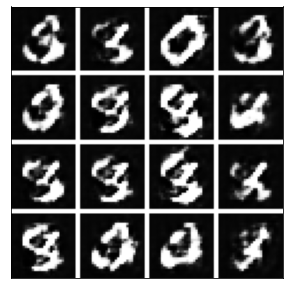

Batch: 1800/3000 [G-Loss: 3.886, D-Loss: 0.071, Accuracy: 96.88%] [Batch time: 0.825 sec, Total time: 25.20 min]



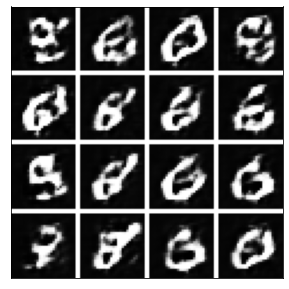

Batch: 1900/3000 [G-Loss: 5.177, D-Loss: 0.035, Accuracy: 100.00%] [Batch time: 0.832 sec, Total time: 26.59 min]



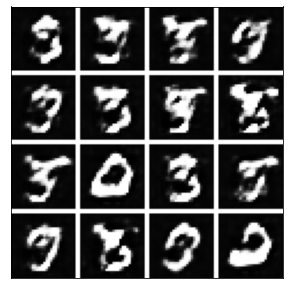

Batch: 2000/3000 [G-Loss: 5.078, D-Loss: 0.046, Accuracy: 96.88%] [Batch time: 0.828 sec, Total time: 27.98 min]



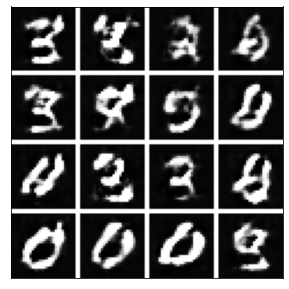

Batch: 2100/3000 [G-Loss: 7.102, D-Loss: 0.253, Accuracy: 84.38%] [Batch time: 0.839 sec, Total time: 29.38 min]



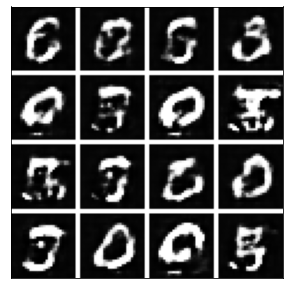

Batch: 2200/3000 [G-Loss: 6.654, D-Loss: 0.666, Accuracy: 81.25%] [Batch time: 0.868 sec, Total time: 30.78 min]



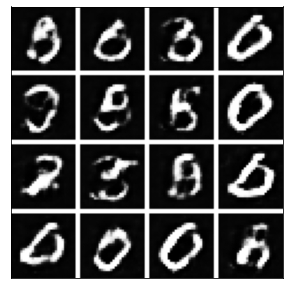

Batch: 2300/3000 [G-Loss: 5.036, D-Loss: 0.058, Accuracy: 96.88%] [Batch time: 0.840 sec, Total time: 32.18 min]



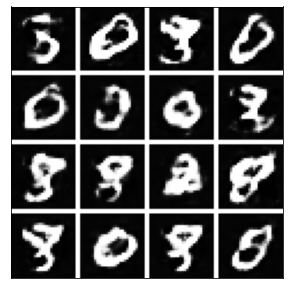

Batch: 2400/3000 [G-Loss: 3.741, D-Loss: 0.150, Accuracy: 96.88%] [Batch time: 0.827 sec, Total time: 33.57 min]



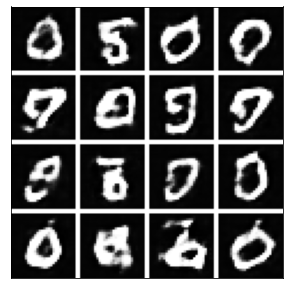

Batch: 2500/3000 [G-Loss: 4.091, D-Loss: 0.074, Accuracy: 93.75%] [Batch time: 0.854 sec, Total time: 34.97 min]



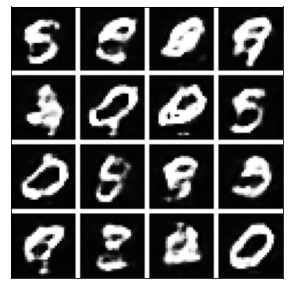

Batch: 2600/3000 [G-Loss: 4.190, D-Loss: 0.042, Accuracy: 100.00%] [Batch time: 0.840 sec, Total time: 36.37 min]



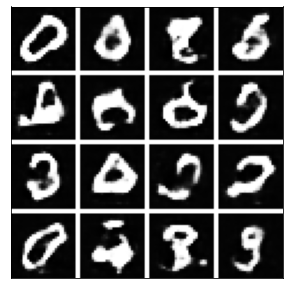

Batch: 2700/3000 [G-Loss: 3.205, D-Loss: 0.809, Accuracy: 59.38%] [Batch time: 0.826 sec, Total time: 37.76 min]



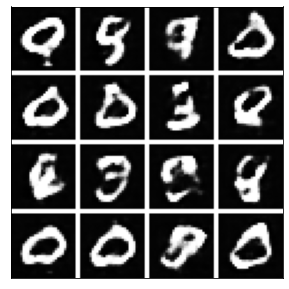

Batch: 2800/3000 [G-Loss: 4.122, D-Loss: 0.172, Accuracy: 93.75%] [Batch time: 0.832 sec, Total time: 39.16 min]



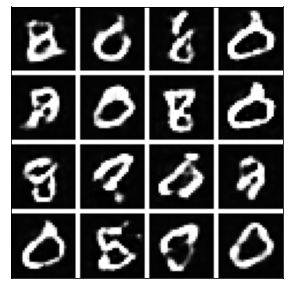

Batch: 2900/3000 [G-Loss: 4.061, D-Loss: 0.111, Accuracy: 96.88%] [Batch time: 0.823 sec, Total time: 40.55 min]



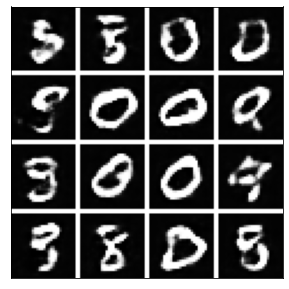

Batch: 3000/3000 [G-Loss: 3.094, D-Loss: 0.079, Accuracy: 100.00%] [Batch time: 0.823 sec, Total time: 41.94 min]



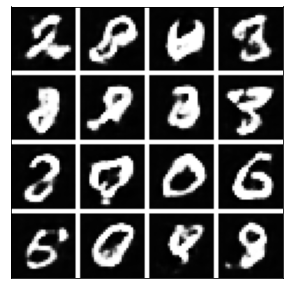

In [10]:
train_model(disc,combined,16,batch_len=3000,data=x)

Testing generator

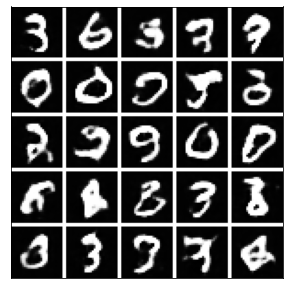

In [11]:
im=gen(tf.random.normal(mean=0,stddev=1,shape=(25,100)))
show_data(im,5,5,w=2,size=(5,5),batch=0)